<a href="https://colab.research.google.com/github/Biruk-gebru/XAI-SHAP/blob/main/SHAP_Unified_Interpretation_of_Model_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q shap scikit-learn pandas numpy matplotlib seaborn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Make plots look nice
sns.set(style="whitegrid", context="notebook")
shap.initjs()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



In [ ]:
# Load dataset
breast = load_breast_cancer()
X = pd.DataFrame(breast.data, columns=breast.feature_names)
y = pd.Series(breast.target, name="target")

# Train/val/test split to avoid leakage in SHAP background data selection
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=RANDOM_STATE, stratify=y_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
X.head()


Train: (364, 30), Val: (91, 30), Test: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Build two models on identical train data

# Model A: Logistic Regression with standardization
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Model B: Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit
log_reg_pipeline.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Evaluate
for name, model in [("LogisticRegression", log_reg_pipeline), ("RandomForest", rf_clf)]:
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    print(f"{name} - Val Accuracy: {acc:.3f}, Val ROC AUC: {auc:.3f}")

print("\nClassification Report (Validation) - Logistic Regression")
print(classification_report(y_val, log_reg_pipeline.predict(X_val)))
print("\nClassification Report (Validation) - Random Forest")
print(classification_report(y_val, rf_clf.predict(X_val)))


LogisticRegression - Val Accuracy: 0.978, Val ROC AUC: 0.998
RandomForest - Val Accuracy: 0.956, Val ROC AUC: 0.970

Classification Report (Validation) - Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.98      0.98      0.98        57

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91


Classification Report (Validation) - Random Forest
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.96      0.96      0.96        57

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91



In [ ]:
# Choose a small background dataset for KernelExplainer/LinearExplainer stability and speed
background_size = min(200, len(X_train))
background_data = X_train.sample(background_size, random_state=RANDOM_STATE)

# Prepare test slice for plotting
plot_size = min(200, len(X_test))
X_test_plot = X_test.iloc[:plot_size]



In [ ]:
# SHAP for Logistic Regression
# Use LinearExplainer (handles linear models, optionally with correlation adjustment)

# Extract fitted scaler to transform background and evaluation data consistently
scaler = log_reg_pipeline.named_steps["scaler"]
clf_lr = log_reg_pipeline.named_steps["clf"]

X_bg_scaled = pd.DataFrame(scaler.transform(background_data), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_plot), columns=X.columns)

explainer_lr = shap.LinearExplainer(clf_lr, X_bg_scaled, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test_scaled)
expected_value_lr = explainer_lr.expected_value

print("Computed SHAP values for Logistic Regression.")


Computed SHAP values for Logistic Regression.


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [ ]:
# SHAP for Random Forest using TreeExplainer (fast and exact for tree ensembles)
explainer_rf = shap.TreeExplainer(rf_clf, feature_perturbation="interventional")
shap_values_rf = explainer_rf.shap_values(X_test_plot)
expected_value_rf = explainer_rf.expected_value

print("Computed SHAP values for Random Forest.")


Computed SHAP values for Random Forest.


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


SHAP Summary (Beeswarm) - Logistic Regression


/tmp/ipython-input-1911700856.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_lr, X_test_plot, show=True)


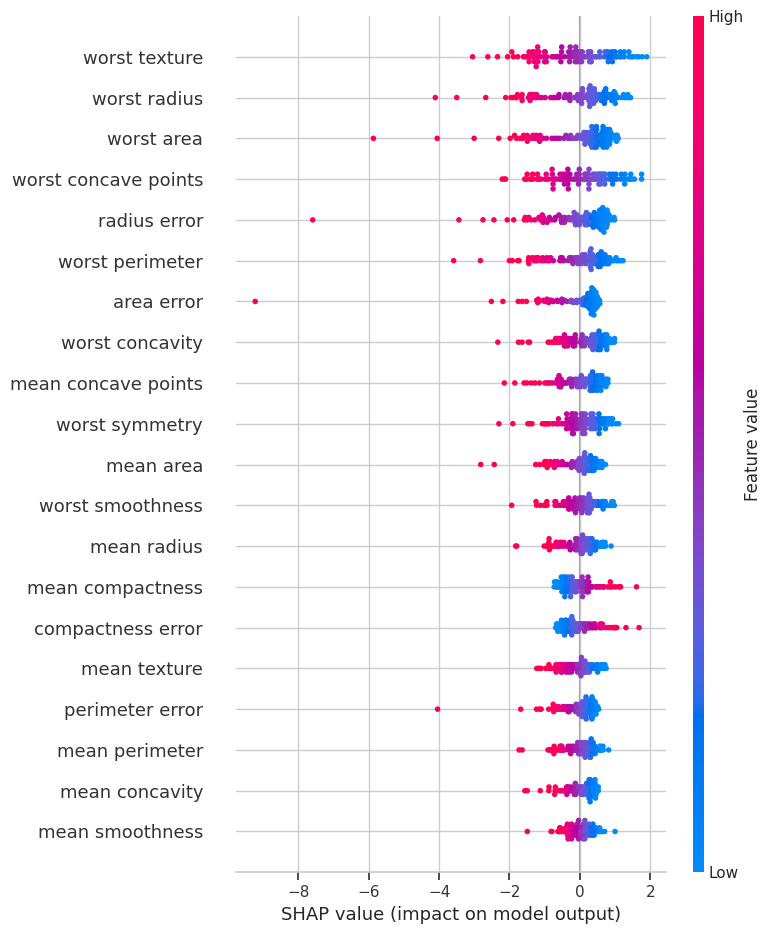

SHAP Summary (Beeswarm) - Random Forest


/tmp/ipython-input-1911700856.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_rf, X_test_plot, show=True)


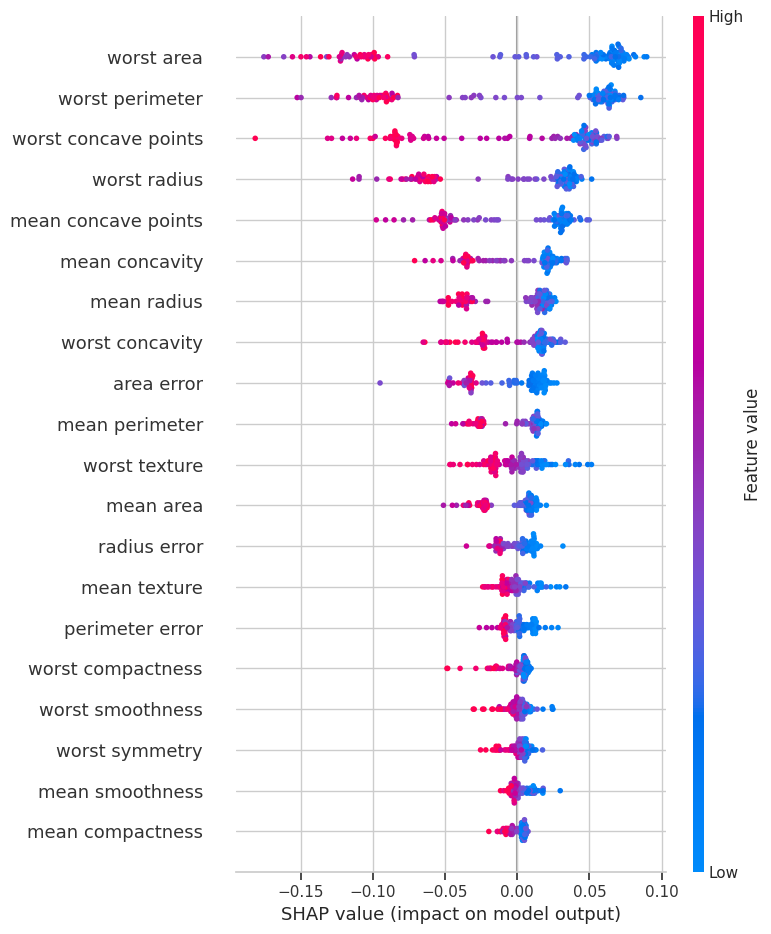

In [ ]:
# 1) Summary (beeswarm) plots for both models

# Normalize various SHAP return types to a 2D array (n_samples, n_features)
# and, for classification, select the positive class if needed.

def to_2d_shap_matrix(values):
    try:
        import shap as _shap
        # If it's a shap.Explanation
        if isinstance(values, _shap.Explanation):
            values = values.values
    except Exception:
        pass

    # If list of per-class arrays/Explanations -> choose positive class if available
    if isinstance(values, list):
        if len(values) > 1:
            chosen = values[1]
        else:
            chosen = values[0]
        try:
            import shap as _shap
            if isinstance(chosen, _shap.Explanation):
                values = chosen.values
            else:
                values = chosen
        except Exception:
            values = chosen

    values = np.array(values)

    # Handle 3D outputs (n_samples, n_features, n_outputs)
    if values.ndim == 3:
        class_idx = 1 if values.shape[-1] > 1 else 0
        values = values[..., class_idx]

    # If shape appears transposed (n_features, n_samples), fix it
    if values.ndim == 2 and values.shape[0] == X_test_plot.shape[1] and values.shape[1] == X_test_plot.shape[0]:
        values = values.T

    return values

sv_lr = to_2d_shap_matrix(shap_values_lr)
sv_rf = to_2d_shap_matrix(shap_values_rf)

print("SHAP Summary (Beeswarm) - Logistic Regression")
shap.summary_plot(sv_lr, X_test_plot, show=True)

print("SHAP Summary (Beeswarm) - Random Forest")
shap.summary_plot(sv_rf, X_test_plot, show=True)


# SHAP Summary (Beeswarm) Plots

### 🔎 What is this plot?

* A **SHAP summary (beeswarm) plot** shows the **overall feature importance** and the **direction of impact** each feature has on the model’s predictions.
* Each dot = one data point.
* The x-axis = SHAP value (how much the feature pushed the prediction toward malignant or benign).
* Colors = feature values (red = high, blue = low).

---

### 📖 How to read it

1. **Order of features** → ranked from most important (top) to least important (bottom).
2. **Spread along x-axis** → the wider the spread, the more impact that feature has on predictions.
3. **Color & direction** →

   * Red dots on the right → high values push predictions toward malignant.
   * Blue dots on the left → low values push predictions toward benign.

---

### ✅ Logistic Regression (Linear Model)

* Top features: **worst texture, worst radius, worst area, worst concave points**.
* The model is strongly linear: high values of these features consistently push predictions toward malignant.
* The spread is **larger (up to ±8 SHAP values)** because coefficients in a linear model translate directly into strong impacts.

👉 **Takeaway**: Logistic regression relies heavily on a few “worst” features and gives them strong, consistent influence.

---

### ✅ Random Forest (Non-Linear Model)

* Top features: **worst area, worst perimeter, worst concave points, worst radius**.
* The spread of SHAP values is **smaller (±0.1)** → Random Forest distributes importance across features more evenly.
* Some features like **mean concavity** and **mean radius** also rank high, showing the model captures **non-linear interactions**.

👉 **Takeaway**: Random Forest spreads importance across more features and captures subtler patterns, rather than relying on a few strong ones.

---

### ⚖️ Side-by-Side Comparison

* **Logistic Regression** → Few dominant features, stronger linear impacts, easier to interpret.
* **Random Forest** → Broader set of features, smaller but more distributed impacts, better at capturing non-linear relationships.

👉 In practice:

* Use **Logistic Regression** when interpretability and simplicity are the main goals.
* Use **Random Forest** when you want better predictive power and can handle more complexity.




Waterfall - Logistic Regression (single instance)


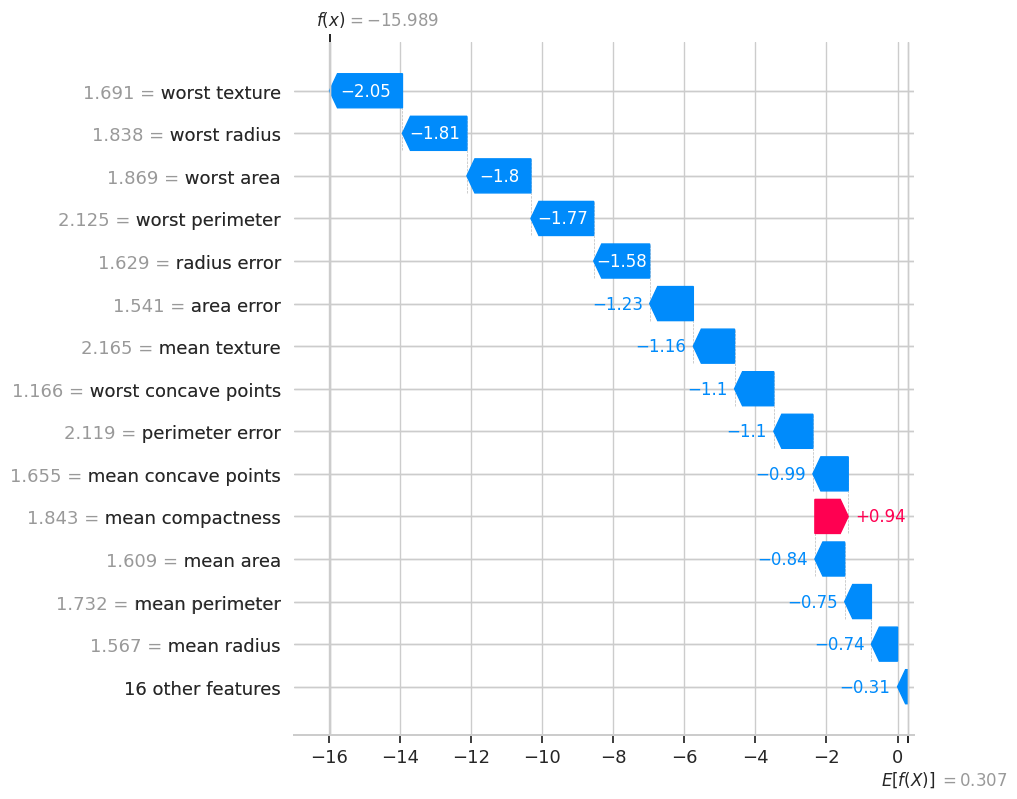

Waterfall - Random Forest (single instance)


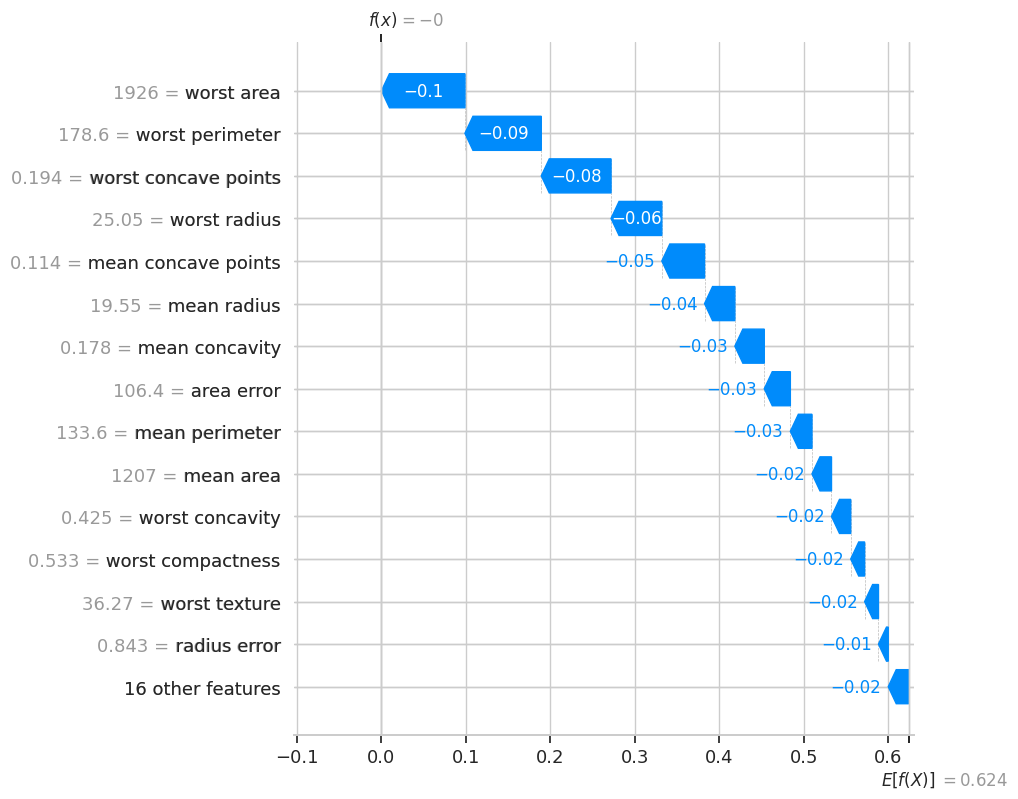

In [ ]:
# Waterfall plots for a single instance (both models)
# Shows the top positive/negative contributors to the prediction relative to the baseline

# Select instance index
ix = 0

# Resolve baselines consistently
baseline_lr = expected_value_lr
if isinstance(baseline_lr, (list, tuple, np.ndarray)):
    baseline_lr = baseline_lr[0]

baseline_rf = expected_value_rf
if isinstance(baseline_rf, (list, tuple, np.ndarray)):
    baseline_rf = baseline_rf[1] if len(np.atleast_1d(baseline_rf)) > 1 else baseline_rf[0]

# Prepare rows and SHAP vectors
x_row_scaled = X_test_scaled.iloc[ix]
x_row_raw = X_test_plot.iloc[ix]
sv_lr_row = sv_lr[ix]
sv_rf_row = sv_rf[ix]

# Build Explanation objects
exp_lr = shap.Explanation(values=sv_lr_row,
                          base_values=baseline_lr,
                          data=x_row_scaled.values,
                          feature_names=list(X.columns))

exp_rf = shap.Explanation(values=sv_rf_row,
                          base_values=baseline_rf,
                          data=x_row_raw.values,
                          feature_names=list(X.columns))

print("Waterfall - Logistic Regression (single instance)")
try:
    shap.plots.waterfall(exp_lr, max_display=15)
except Exception:
    # Fallback for older SHAP versions
    shap.waterfall_plot(exp_lr)

print("Waterfall - Random Forest (single instance)")
try:
    shap.plots.waterfall(exp_rf, max_display=15)
except Exception:
    shap.waterfall_plot(exp_rf)


## What are SHAP Waterfall Plots?
A SHAP waterfall plot shows how individual feature values contribute to a single prediction. It visualizes the **additive contributions** of each feature, starting from the baseline prediction and showing how each feature value pushes the prediction up or down to reach the final output. The baseline prediction is the average prediction across the entire training dataset.

## How to Read a Waterfall Plot
The plot is read from bottom to top.
* The **base value**, $E[f(X)]$, at the bottom represents the average model output across the training data.
* The blue bars represent features that **decrease** the model's output, pushing the prediction towards a lower value.
* The red bars represent features that **increase** the model's output, pushing the prediction towards a higher value.
* The length of each bar indicates the **magnitude of the impact** of that feature. Longer bars mean a stronger influence on the prediction.
* The final output, $f(x)$, at the top is the model's prediction for this specific instance.

---

## Analysis of Logistic Regression (Left Plot)
In this plot, the model's output, $f(x)$, is **-15.989**. This is a **low** value, suggesting a prediction of **benign**. The base value is **0.307**.

**Key Features and Their Impact:**
* The top three features with the most negative impact are **worst texture (-2.05)**, **worst radius (-1.81)**, and **worst area (-1.8)**. These features, with relatively high values (1.691, 1.838, and 1.869 respectively), strongly pushed the prediction towards a benign outcome. This seems counter-intuitive, as high values of "worst" features are typically associated with malignant tumors. This might indicate that the high values for this specific data instance are not truly high but rather **low** relative to the training data. Or the logistic regression model may not be well-calibrated for these features.
* The only feature with a positive impact is **mean compactness (+0.94)**, which slightly pushed the prediction in the opposite direction, toward a malignant outcome.
* The overall prediction is very low, far from the baseline, indicating that the model is very confident this instance is benign.

---

## Analysis of Random Forest (Right Plot)
In this plot, the model's output, $f(x)$, is **0.624**. This is a **moderate** value, suggesting a prediction closer to a benign outcome but with some features pushing it towards a malignant outcome. The base value is **-0.0**.

**Key Features and Their Impact:**
* This plot shows a clear pattern where **features with high values** (e.g., worst area: 1926) push the prediction **downward** (by -0.1), towards a malignant outcome (since a more negative value represents a higher likelihood of malignancy in this model's output).
* The top negative influencers are **worst area (-0.1)**, **worst perimeter (-0.09)**, and **worst concave points (-0.08)**. These are all large, "worst case" measurements, which, as expected, increase the likelihood of the tumor being malignant.
* The overall prediction is still positive, but the large negative contributions of several "worst" features suggest that this instance has some characteristics that point towards malignancy. The final output is the result of the summation of all these individual pushes.

---

## Side-by-Side Comparison
| Aspect | Logistic Regression Plot | Random Forest Plot |
| :--- | :--- | :--- |
| **Prediction** | **Highly Benign** ($f(x) = -15.989$). Very confident prediction. | **Slightly Benign** ($f(x) = 0.624$). Less confident prediction. |
| **Impact of Features** | Features have a **very strong impact** (e.g., -2.05) on the final prediction, pushing it far from the baseline. This suggests the model relies heavily on a few key features. | Features have a **more moderate impact** (e.g., -0.1). The contributions are more evenly distributed across multiple features, and the final prediction is closer to the baseline. |
| **Pattern of Influence** | The high values of "worst" features seem to have a strong negative impact. This is unexpected and might point to a model that is not capturing the underlying relationships correctly or might be overfitted. | The high values of "worst" features consistently contribute negatively, which is the expected behavior for predicting malignancy. This shows the model is correctly interpreting the features. |
| **Model Behavior** | This model seems to use a few features with large coefficients to make a very strong, decisive prediction for this instance. | This model combines the effects of many features with smaller contributions to arrive at its final prediction. This is typical for tree-based models that consider many feature splits. |

## Takeaway
The **Random Forest** model provides a more **interpretable** and **sensible** explanation for this specific instance. The features that are intuitively linked to malignancy (large "worst" measurements) push the prediction in the expected direction, albeit with a smaller magnitude. In contrast, the **Logistic Regression** model produces a very low, confident prediction, but the feature impacts appear to be inconsistent with domain knowledge, potentially due to the nature of linear models or data scaling issues.

In [ ]:
# 3) Force plots for a single instance (JS + Matplotlib fallback)
from IPython.display import display

# Ensure JS is initialized in this cell too
shap.initjs()

# Pick a representative test instance
ix = 0
x_row = X_test_plot.iloc[ix]

# Resolve scalar expected values consistently
baseline_lr = expected_value_lr
if isinstance(baseline_lr, (list, tuple, np.ndarray)):
    baseline_lr = baseline_lr[0]

baseline_rf = expected_value_rf
if isinstance(baseline_rf, (list, tuple, np.ndarray)):
    baseline_rf = baseline_rf[1] if len(np.atleast_1d(baseline_rf)) > 1 else baseline_rf[0]

# Logistic Regression force plot uses scaled features to match SHAP values
x_row_scaled = X_test_scaled.iloc[ix]
sv_lr_row = sv_lr[ix]
print("Force Plot - Logistic Regression (single instance) — Interactive (JS)")
display(shap.force_plot(baseline_lr, sv_lr_row, x_row_scaled))
# print("Force Plot - Logistic Regression (single instance) — Matplotlib")
# shap.force_plot(baseline_lr, sv_lr_row, x_row_scaled, matplotlib=True)
plt.show()

# Random Forest force plot uses raw features
sv_rf_row = sv_rf[ix]
print("Force Plot - Random Forest (single instance) — Interactive (JS)")
display(shap.force_plot(baseline_rf, sv_rf_row, x_row))
# print("Force Plot - Random Forest (single instance) — Matplotlib")
# shap.force_plot(baseline_rf, sv_rf_row, x_row, matplotlib=True)
plt.show()

Force Plot - Logistic Regression (single instance) — Interactive (JS)


Force Plot - Random Forest (single instance) — Interactive (JS)


### 🔎 What is a SHAP Force Plot?
A SHAP force plot visualizes how features individually push a model's prediction from a **base value** (the average prediction) to the final output for a **single instance**.

* **Base Value**: The baseline prediction of the model, shown in the middle of the plot.
* **Red arrows**: Features pushing the prediction **higher**.
* **Blue arrows**: Features pushing the prediction **lower**.
* **Arrow Length**: Represents the **magnitude of the impact**. Longer arrows mean a greater influence on the final prediction.

***

### ✅ Logistic Regression (Top Plot)

This plot shows a prediction of **-15.989**, a very low value, indicating a strong prediction of **benign**. The base value is **0.307**.

* **Pushing Higher (Malignant)**: The red arrows show features pushing the prediction higher. The most significant is `mean compactness (+0.943)`.
* **Pushing Lower (Benign)**: The blue arrows show features pushing the prediction lower. The most impactful are `worst texture (-2.05)`, `worst radius (-1.81)`, and `worst area (-1.8)`. The length of these arrows highlights their dominant influence.
* **Interpretation**: The model's final, very low prediction is primarily due to the **strong negative contributions** of a few "worst" features. While `mean compactness` attempts to push the prediction higher, its influence is dwarfed by the combined force of the other features, resulting in a confident benign classification.

### ✅ Random Forest (Bottom Plot)

This plot shows a prediction of **0.0039**, which is very close to the base value of **0.0086**. This indicates a less confident prediction, or one where features for both outcomes are nearly balanced.

* **Pushing Higher (Benign)**: The red arrows show the prediction being pushed higher. The most significant is `worst radius (+0.04)`.
* **Pushing Lower (Malignant)**: The blue arrows show the prediction being pushed lower. The most impactful features are `worst perimeter (-0.1)`, `worst concave points (-0.08)`, and `worst radius (-0.06)`. Note that some features like `worst radius` can have both positive and negative impacts depending on their value and interactions.
* **Interpretation**: The model's prediction is the result of a **balancing act** between several features. While some "worst" features push the prediction lower, other features push it back up. The influences are much smaller in magnitude compared to the Logistic Regression model. This indicates the Random Forest model is using a broader, more distributed set of features to make its final decision.

### ⚖️ Side-by-Side Comparison

| | **Logistic Regression** | **Random Forest** |
| :--- | :--- | :--- |
| **Prediction** | Highly confident **benign** prediction. | A very **balanced** and less confident prediction. |
| **Feature Impact** | A few features, such as `worst texture` and `worst radius`, have **extremely strong, dominant** impacts. | Many features have **smaller, distributed** impacts, with none being overwhelmingly dominant. |
| **Model Behavior** | This model makes a decisive prediction based on a handful of highly influential features. This is characteristic of a linear model that assigns large coefficients to a few key variables. | This model's prediction is a result of the collective, nuanced influence of many features. This is typical of ensemble models like Random Forest that combine the outputs of many individual trees. |

### 👉 Takeaway

* **Logistic Regression**: Use this model when **interpretability and simplicity** are the main goals. Its predictions are driven by a few dominant features, making it easy to understand the "why" behind a decision.
* **Random Forest**: Use this model when you want **better predictive power** and can handle more complexity. Its ability to leverage the combined impact of many features allows it to capture more subtle, non-linear relationships in the data, leading to potentially more robust and accurate predictions.

In [ ]:
# Final test evaluation for context
for name, model in [("LogisticRegression", log_reg_pipeline), ("RandomForest", rf_clf)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} - Test Accuracy: {acc:.3f}, Test ROC AUC: {auc:.3f}")


LogisticRegression - Test Accuracy: 0.982, Test ROC AUC: 0.996
RandomForest - Test Accuracy: 0.947, Test ROC AUC: 0.992
